In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training dataset setup

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [ ]:
DATADIR = '/content/drive/Shareddrives/AAML_final/Training_Dataset'
CATEGORIES = ['Fire', 'NoFire']

In [ ]:
IMG_SIZE = 64
def create_training_data():
    training_data = []
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category) 
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=C 1=O

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
              
    return training_data

In [ ]:
training_data = create_training_data()

100%|██████████| 1301/1301 [00:32<00:00, 39.52it/s]


In [ ]:
import random

print(len(training_data))
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

2423
1
0
1
1
0
0
0
1
0
1


In [ ]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X = X/255.0
Y = np.array(Y)
X.shape[1:]

(64, 64, 3)


# Hyperparameter

In [ ]:
BATCHSIZE_ = 32
EPOCHS_ = 100
VALIDATION_SPLIT_ = 0.3

In [ ]:
# # set up image augmentation
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range=15,
#     horizontal_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1
#     #zoom_range=0.3
#     )
# datagen.fit(X)

# Non Pruning model training

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, AveragePooling2D

model = Sequential()


model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=X.shape[1:]))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=2, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X, Y, batch_size=BATCHSIZE_, epochs=EPOCHS_, validation_split=VALIDATION_SPLIT_)
# model.fit_generator(datagen.flow(X, Y, batch_size=32),
#                     epochs=100,
#                     verbose=1)

In [ ]:
model.save('/content/drive/Shareddrives/AAML_final/FireNet-LightWeight-Network-for-Fire-Detection/Trained_Model_FIreNet/train_nonpruning.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 average_pooling2d (AverageP  (None, 31, 31, 16)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 31, 31, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 14, 14, 32)       0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0

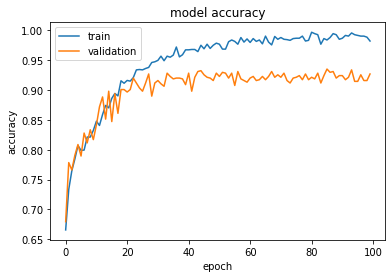

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

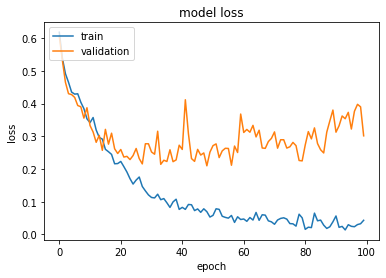

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
model = tf.keras.models.load_model('/content/drive/Shareddrives/AAML_final/FireNet-LightWeight-Network-for-Fire-Detection/Trained_Model_FIreNet/train_nonpruning.h5')

# model.fit_generator(datagen.flow(X, Y, batch_size=32),
#                     epochs=100,
#                   verbose=1)


In [ ]:
 from tensorflow.keras.utils import plot_model
 plot_model(model, to_file='model_small.png', show_layer_names=False, show_shapes=True)

# Pruning Model training

In [ ]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 213 kB 5.1 MB/s 


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/Shareddrives/AAML_final/FireNet-LightWeight-Network-for-Fire-Detection/Trained_Model_FIreNet/train_nonpruning.h5') # optional

In [ ]:
BATCHSIZE_ = 32
EPOCHS_ = 100
VALIDATION_SPLIT_ = 0.3

In [ ]:
import tensorflow_model_optimization as tfmot

#prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

num_images = X.shape[0] * (1 - VALIDATION_SPLIT_)
end_step = np.ceil(num_images / BATCHSIZE_).astype(np.int32) * EPOCHS_

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.5, begin_step=0, end_step=end_step, frequency=100)
      #tfmot.sparsity.keras.PolynomialDecay( initial_sparsity=0,
      #                              final_sparsity=0.80,
      #                              begin_step=0,
      #                              end_step=end_step )
}

#model_for_pruning = prune_low_magnitude(model, **pruning_params)

# Helper function uses `prune_low_magnitude` to make only the 
def apply_pruning_to_Conv2D(layer):
  if isinstance(layer, tf.keras.layers.Conv2D):
    return tfmot.sparsity.keras.prune_low_magnitude(layer)
  return layer

model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_Conv2D,
)

# `prune_low_magnitude` requires a recompile.
prun_history = model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

In [ ]:
import tempfile
import os

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(X, Y,
           batch_size=BATCHSIZE_, epochs=EPOCHS_, validation_split=VALIDATION_SPLIT_,
           callbacks=callbacks)

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmpytbpwu3l.h5


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpx3cwqvja/assets


INFO:tensorflow:Assets written to: /tmp/tmpx3cwqvja/assets


Saved pruned TFLite model to: /tmp/tmplq1llcri.tflite


In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import tempfile
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size('/content/drive/Shareddrives/AAML_final/FireNet-LightWeight-Network-for-Fire-Detection/Trained_Model_FIreNet/train_nonpruning.h5')))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size('/content/drive/Shareddrives/AAML_final/FireNet-LightWeight-Network-for-Fire-Detection/Trained_Model_FIreNet/all_prun_0_80.h5')))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size('/content/drive/Shareddrives/AAML_final/FireNet-LightWeight-Network-for-Fire-Detection/Trained_Model_FIreNet/pruned_quantized_4bit_DenseLayerOnly_model.tflite')))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size('/content/drive/Shareddrives/AAML_final/FireNet-LightWeight-Network-for-Fire-Detection/Trained_Model_FIreNet/pruned_quantized_8bit_DenseLayerOnly_model.tflite')))


# Quantization


In [ ]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 213 kB 7.6 MB/s 


In [ ]:

import tensorflow as tf
base_model = tf.keras.models.load_model('/content/drive/Shareddrives/AAML_final/FireNet-LightWeight-Network-for-Fire-Detection/Trained_Model_FIreNet/pruning1.h5') # optional

OSError: ignored

In [ ]:
import tensorflow_model_optimization as tfmot

# Helper function uses `quantize_annotate_layer` to annotate that only the 
# Dense layers should be quantized.
def apply_quantization_to_dense(layer):
  if isinstance(layer, tf.keras.layers.Dense):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_quantization_to_dense` 
# to the layers of the model.
annotated_model = tf.keras.models.clone_model(
    base_model,
    clone_function=apply_quantization_to_dense,
)

# Now that the Dense layers are annotated,
# `quantize_apply` actually makes the model quantization aware.
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

quant_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 average_pooling2d (AverageP  (None, 31, 31, 16)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 31, 31, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 14, 14, 32)       0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0

In [ ]:
BATCHSIZE_ = 32
EPOCHS_ = 100
VALIDATION_SPLIT_ = 0.3

In [ ]:
quant_aware_model.fit(X, Y,
           batch_size=BATCHSIZE_, epochs=EPOCHS_, validation_split=VALIDATION_SPLIT_,
           )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


53/53 [==============================] - 8s 122ms/step - loss: 0.1979 - accuracy: 0.9581 - val_loss: 0.0582 - val_accuracy: 0.9794
Epoch 2/100
53/53 [==============================] - 6s 117ms/step - loss: 0.1113 - accuracy: 0.9670 - val_loss: 0.0485 - val_accuracy: 0.9835
Epoch 3/100
53/53 [==============================] - 6s 118ms/step - loss: 0.0793 - accuracy: 0.9746 - val_loss: 0.0621 - val_accuracy: 0.9821
Epoch 4/100
53/53 [==============================] - 6s 118ms/step - loss: 0.0672 - accuracy: 0.9741 - val_loss: 0.0390 - val_accuracy: 0.9876
Epoch 5/100
53/53 [==============================] - 6s 117ms/step - loss: 0.0598 - accuracy: 0.9788 - val_loss: 0.0648 - val_accuracy: 0.9821
Epoch 6/100
53/53 [==============================] - 6s 118ms/step - loss: 0.0637 - accuracy: 0.9829 - val_loss: 0.0643 - val_accuracy: 0.9821
Epoch 7/100
53/53 [==============================] - 6s 117ms/step - loss: 0.0594 - accuracy: 0.9764 - val_loss: 0.0612 - val_accuracy: 0.9807
Epoch 8/100

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpjvx1dv1f/assets


INFO:tensorflow:Assets written to: /tmp/tmpjvx1dv1f/assets


In [ ]:
import tempfile
import os

_, quanted_tflite_file = tempfile.mkstemp('.tflite')

with open(quanted_tflite_file, 'wb') as f:
  f.write(quantized_tflite_model)

print('Saved quanted TFLite model to:', quanted_tflite_file)

Saved quanted TFLite model to: /tmp/tmp4j31w6lf.tflite


In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
print("Size of gzipped quanted TFlite model: %.2f bytes" % (get_gzipped_model_size(quanted_tflite_file)))

Size of gzipped quanted TFlite model: 755763.00 bytes
